Research Questions:
    
    1) How many teams in each country?
    2) Which team's performance improved the most over the past seasons?
    3) Which team/player have the most cards over the past seasons?
    
    4) What team attribute most likely leads to victory?
    5) What player attribute most likely leads to victory?
  
    6) What is the average score per game per team in a match?
    7) What is the average score per game per player in a match?
    
    8) Which player has the most consistancy good performance?
    9) Which team has the most consistancy good performnace?
    
    10) Which team has the most influence over the location of the match? ( home or away)
    
  
    
    
    

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

In [5]:
path = "/users/danqi/desktop/"  #Insert path here
database = path + 'database.sqlite'

In [6]:
# review what tables is in sqlite DB
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


Time to explore our data to answer some simple questions like, how many teams are there in each country? What team names and league names do they have?

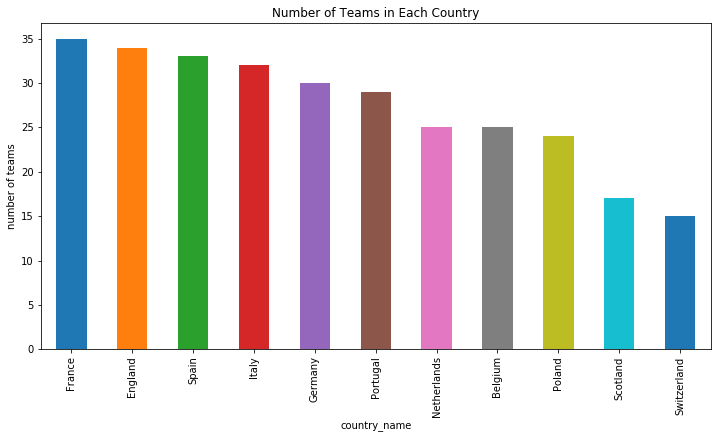

In [9]:
# How many teams does each country have?

country_team=countries.groupby('country_name').count()['team_name'].sort_values(ascending=False)
result=country_team.plot(kind='bar',figsize=(12,6),title='Number of Teams in Each Country')
result.set_ylabel('number of teams');

In [8]:
#What are the teams in each country? And what are the league name accordingly.

countries = pd.read_sql("""SELECT DISTINCT c.name AS country_name, t.team_long_name AS team_name,t.team_short_name, l.name AS league_name
FROM Match m JOIN Team t ON
m. home_team_api_id= t.team_api_id JOIN Country c ON
m.country_id=c.id JOIN League l ON
l.country_id= c.id;""", conn)

countries.head(15)

,country_name,team_name,team_short_name,league_name
0,Belgium,KRC Genk,GEN,Belgium Jupiler League
1,Belgium,SV Zulte-Waregem,ZUL,Belgium Jupiler League
2,Belgium,KSV Cercle Brugge,CEB,Belgium Jupiler League
3,Belgium,KAA Gent,GEN,Belgium Jupiler League
4,Belgium,FCV Dender EH,DEN,Belgium Jupiler League
5,Belgium,KV Mechelen,MEC,Belgium Jupiler League
6,Belgium,KSV Roeselare,ROS,Belgium Jupiler League
7,Belgium,Tubize,TUB,Belgium Jupiler League
8,Belgium,KVC Westerlo,WES,Belgium Jupiler League
9,Belgium,Club Brugge KV,CLB,Belgium Jupiler League


Research Question 1: Which country has the best performance?


We know the number of teams in each country, now let us see which country have the best performance, in terms of average goal scored over the period. 


Also it would be intersting to see if the number of teams have a positive correlation with the performance. Is it true that more teams a country has, the more likely they have stronger performance?


In [10]:

# first join the team and match tables, so we have the information of home goal, away goal each team have scored in the matches

country_match= pd.read_sql(
    
    """SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                    
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                               
                                ORDER by date;
                                """, conn) 

country_match.head()

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18 00:00:00,BSC Young Boys,FC Basel,1,2
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19 00:00:00,FC Aarau,FC Sion,3,1
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,FC Luzern,FC Vaduz,1,2
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,Neuchâtel Xamax,FC Zürich,1,2
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,FC Basel,Grasshopper Club Zürich,1,0


Let us convert the date into more workable format.

In [11]:
country_match['date'] = pd.to_datetime(country_match['date'] )
country_match['year']=country_match['date'].dt.year
#country_match['month']=country_match['date'].dt.month

Since we want to answer the question on the country/year level, i would like to remove the unrelevant columns for this research question by creating a new dateframe containing only country, year, goal information.

In [12]:
ctry_avg_score=country_match.groupby(['country_name','year']).mean()[['home_team_goal','away_team_goal']].reset_index('year')
ctry_avg_score['total_goal']=ctry_avg_score['home_team_goal']+ctry_avg_score['away_team_goal']
ctry_avg_score['home_away_difference']=ctry_avg_score['home_team_goal']-ctry_avg_score['away_team_goal']
ctry_avg_score.head()

,year,home_team_goal,away_team_goal,total_goal,home_away_difference
country_name,,,,,
Belgium,2008,1.712418,1.143791,2.856209,0.568627
Belgium,2009,1.521886,1.208754,2.730640,0.313131
Belgium,2010,1.627193,1.135965,2.763158,0.491228
Belgium,2011,1.573913,1.069565,2.643478,0.504348
Belgium,2012,1.719697,1.325758,3.045455,0.393939


Here, let us transform the data with country in the columns and year as the row, and average goal scored per year as value. This way we can make line chart/box plot with the dataframe.

In [13]:
df_avg_goal = pd.DataFrame(index=np.sort(ctry_avg_score['year'].unique()), columns=ctry_avg_score.index.unique())
df_home_away_diff=pd.DataFrame(index=np.sort(ctry_avg_score['year'].unique()), columns=ctry_avg_score.index.unique())

lst=['Switzerland', 'Poland', 'France', 'Scotland', 'Germany','Belgium', 'England', 'Portugal', 'Netherlands', 'Italy', 'Spain']
for i in lst:
    df_avg_goal.loc[:,i] = list(ctry_avg_score.loc[ctry_avg_score.index==i,'total_goal'])
    df_home_away_diff.loc[:,i]= list(ctry_avg_score.loc[ctry_avg_score.index==i,'home_away_difference'])

    

check the head of two new df

In [14]:
df_avg_goal.head()

country_name,Belgium,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
2008,2.856209,2.585859,2.226316,3.019608,2.467456,3.098039,2.147059,2.104167,2.550847,2.937500,2.839080
2009,2.730640,2.650794,2.381963,2.781046,2.631300,2.777419,2.245833,2.398438,2.400943,2.827027,3.262295
2010,2.763158,2.647059,2.330709,3.032680,2.501312,3.028481,2.281250,2.529167,2.665217,2.702564,3.188889
2011,2.643478,2.883289,2.458115,2.781046,2.579088,3.287671,2.308594,2.521552,2.469636,2.705263,2.788889
2012,3.045455,2.813299,2.534211,2.879085,2.730159,3.171429,2.361607,2.740260,2.771930,2.848718,2.456790


In [15]:
df_home_away_diff.head()

country_name,Belgium,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
2008,0.568627,0.161616,0.289474,0.535948,0.633136,0.705882,0.558824,0.187500,0.211864,0.462500,0.425287
2009,0.313131,0.534392,0.334218,0.290850,0.339523,0.429032,0.354167,0.242188,0.287736,0.410811,0.617486
2010,0.491228,0.534759,0.341207,0.300654,0.496063,0.655063,0.477679,0.329167,0.126087,0.538462,0.322222
2011,0.504348,0.379310,0.426702,0.480392,0.359249,0.678082,0.410156,0.202586,0.259109,0.552632,0.322222
2012,0.393939,0.414322,0.418421,0.310458,0.375661,0.358730,0.165179,0.212121,0.043860,0.541026,0.283951


let us first exam the overall average goal scored by each country by plotting boxplot:

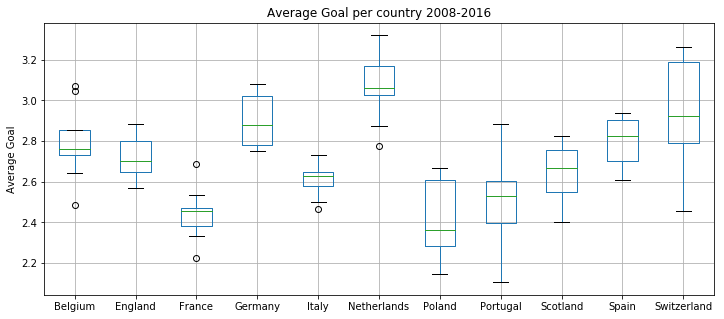

In [16]:
result=df_avg_goal.boxplot(figsize=(12,5))
plt.title('Average Goal per country 2008-2016')
result.set_ylabel('Average Goal');

Let us Rank the top 5 most scored countries by the average number of goals from 2008-2016:

1) the Netherlands
2) SwitzerLand
3) Germany
4) Spain
5) Belguim

You can see from boxplot that although Switzerland and the Netherlands have higher average goals, it seems that Germany has relatively stable performance given its max and min are closesr to its median. We will double check this assumption later with avg score development over time.

Part of our first research question is to answer, is there a positve correlation between nr of teams and country performance? Looking at above picture, it seems that higher number of teams does't alway yield to higher performance. e.g. England and France.

Let us test this hypothesis by plotting both number of teams and overall performance in a line graph.

To do that, we need to merge two datafarmes: avg number of scores and nr of teams together.

In [17]:
# the avg score per country
df1=pd.DataFrame(df_avg_goal.mean().sort_values(ascending=False))
df1.index.names = ['list_country']
df1.reset_index(inplace=True)
df1

,list_country,0
0,Netherlands,3.071763
1,Switzerland,2.934726
2,Germany,2.904905
3,Belgium,2.798296
4,Spain,2.785173
5,England,2.708517
6,Scotland,2.639337
7,Italy,2.607159
8,Portugal,2.518122
9,France,2.444712


In [18]:
# the number of team
df2=pd.DataFrame(country_team)
df2.reset_index(inplace=True)
df2

,country_name,team_name
0,France,35
1,England,34
2,Spain,33
3,Italy,32
4,Germany,30
5,Portugal,29
6,Netherlands,25
7,Belgium,25
8,Poland,24
9,Scotland,17


In [19]:
# merge the two
df=df1.merge(df2, how='inner',left_on='list_country',right_on='country_name')
df.columns = ['list_country', 'avg_score','country_name','nr_teams']
df.drop('country_name',axis=1,inplace=True)
df

,list_country,avg_score,nr_teams
0,Netherlands,3.071763,25
1,Switzerland,2.934726,15
2,Germany,2.904905,30
3,Belgium,2.798296,25
4,Spain,2.785173,33
5,England,2.708517,34
6,Scotland,2.639337,17
7,Italy,2.607159,32
8,Portugal,2.518122,29
9,France,2.444712,35


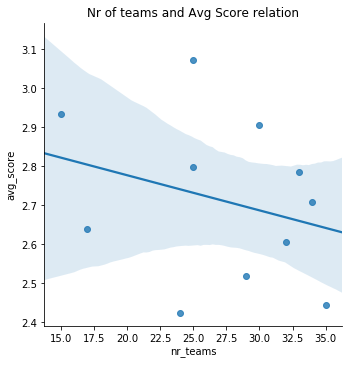

In [20]:
ax=sns.lmplot(x='nr_teams',y='avg_score',data=df)
plt.title("Nr of teams and Avg Score relation");

The best fitting line shown above does not do a good job in finding the relation between these two variables. We can not see the p-value here, but given the number of dots outside the confidence interval, it is obivous that the fitting is not significant.

Therefore, it confirms that nr of teams does not correlate to a good performance for the country.

So far, we have answered the first question, but since we also have the information about the difference between home and away goals, it would be interesting to explore which country have the most consistant performance regardless of game location. Which country is more likely to win if they play at home?

Research question 2:    

which country is more likely to win a game if they play at home?


which country is more consistant on the performance regardless of their game location?

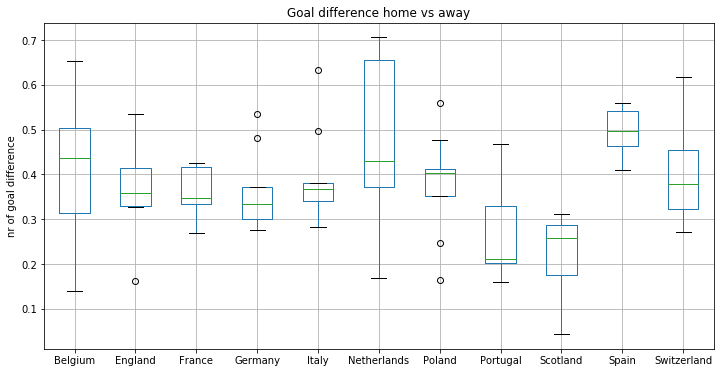

In [21]:
ax1=df_home_away_diff.boxplot(figsize=(12,6))
plt.title('Goal difference home vs away')
ax1.set_ylabel('nr of goal difference');

Frist of all, it is not surprising that all the countries score more at home game than away game- given all the nr of goal difference is above 0.

Secondly, we see Spanish Team is more likely to be impacted by the location of team, followed by Dutch Team. These two teams will on average score 0.4-0.5 goals more per match if they play at a home game.

Thridly, we can see team Portugal is least likely to be impacted by the location of game. 

Now Let us move on to analysis the performance development over the years to answer the following question:

Research Question 3:

Which team's performance have developed the most over the years?


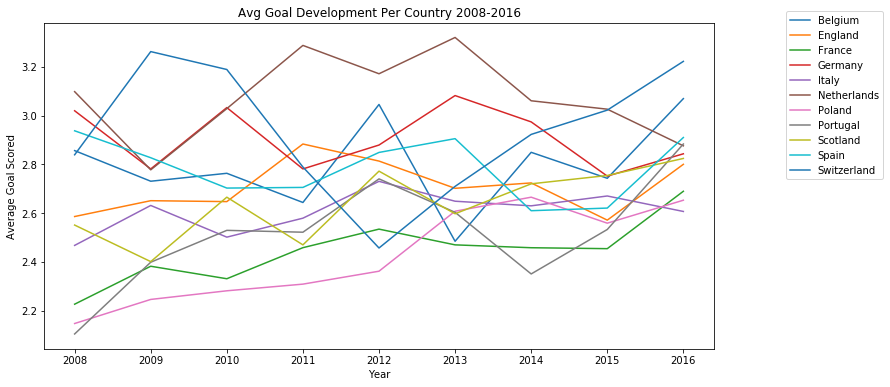

In [28]:
# plot the country line graph over the time period 
result=df_avg_goal.plot(figsize=(12,6))
result.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Avg Goal Development Per Country 2008-2016')
plt.xlabel('Year')
plt.ylabel('Average Goal Scored');

The graph looks very busy above, let us zoom in only focusing on the top 5 teams we have ranked earlier: NL, SW, DE, ES, BE

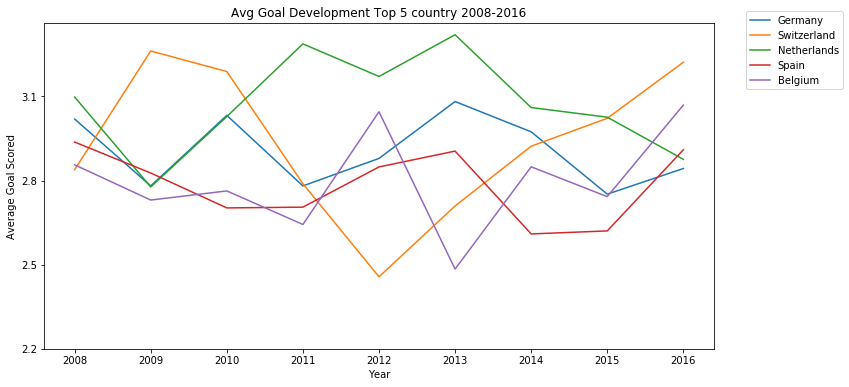

In [49]:
top_5=df_avg_goal[['Germany','Switzerland','Netherlands', 'Spain','Belgium']].plot(figsize=(12,6))
top_5.legend(bbox_to_anchor=(1.2, 1.05))
plt.title('Avg Goal Development Top 5 country 2008-2016')
plt.xlabel('Year')
plt.ylabel('Average Goal Scored')
plt.yticks((2.2,2.5,2.8,3.1));


We can see that over the period of 2008-2016, Germany, Spain, Belgium teams have the relatively stable performance. 
e.g. Germany scored about avg 3 goals per match in 2016 which is about the same level as it performed in 2008.

On the contrary, the Netherlands and Switzerland had some flucations in performance comparing to the other teams:

We can see NL team was very strong over the year of 2010-2013, but the performance went down dramatically since 2013.
For SW, the performance went down hill from 2009-2011, but it recovered significally since 2012.

From here, we can go a little deeper to investigate the reason behind the fluctuation in team NL, SW's performance. Can this be explained by certain team's performance?

In [196]:
SW_NL= pd.read_sql(
    
    """SELECT Match.id, 
                                        Country.name AS country_name, 
                                    
                
                                        date,
                                    
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal
                            
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name='Netherlands' OR country_name='Switzerland'
                                ORDER by date;
                                """, conn) 

SW_NL.head()

,id,country_name,date,home_team,away_team,home_team_goal,away_team_goal
0,24559,Switzerland,2008-07-18 00:00:00,BSC Young Boys,FC Basel,1,2
1,24560,Switzerland,2008-07-19 00:00:00,FC Aarau,FC Sion,3,1
2,24561,Switzerland,2008-07-20 00:00:00,FC Luzern,FC Vaduz,1,2
3,24562,Switzerland,2008-07-20 00:00:00,Neuchâtel Xamax,FC Zürich,1,2
4,24613,Switzerland,2008-07-23 00:00:00,FC Basel,Grasshopper Club Zürich,1,0


In [197]:
#convert date 
SW_NL['date']=pd.to_datetime(SW_NL['date'])
SW_NL['year']=SW_NL['date'].dt.year

In [198]:
df_home_goal=SW_NL.groupby(['home_team','year']).mean()['home_team_goal']
df_away_goal=SW_NL.groupby(['away_team','year']).mean()['away_team_goal']

In [199]:
df_home_goal=pd.DataFrame(df_home_goal).reset_index('year')
df_home_goal=df_home_goal[df_home_goal.index.value_counts()==9]

df_away_goal=pd.DataFrame(df_away_goal).reset_index('year')
df_away_goal=df_away_goal[df_away_goal.index.value_counts()==9]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [200]:
df_home_goal.head()

,year,home_team_goal
home_team,,
ADO Den Haag,2008,0.875000
ADO Den Haag,2009,1.222222
ADO Den Haag,2010,1.705882
ADO Den Haag,2011,1.875000
ADO Den Haag,2012,1.333333


In [201]:
df_away_goal.columns=['year_aw','away_goal']
df_away_goal.reset_index(inplace=True)

In [202]:
df_home_goal.reset_index(inplace=True)

In [203]:
new_df = pd.merge(df_away_goal, df_home_goal,  how='left', left_on=['away_team','year_aw'], right_on = ['home_team','year'])

In [204]:
new_df.drop(['home_team','year_aw'],axis=1,inplace=True)

In [207]:
new_df.set_index('away_team',inplace=True)

In [208]:
new_df['total_goal']=new_df['away_goal']+new_df['home_team_goal']

In [211]:
list_team=list(new_df.index.unique())

In [212]:
list_team

['ADO Den Haag',
 'AZ',
 'Ajax',
 'BSC Young Boys',
 'FC Basel',
 'FC Groningen',
 'FC Luzern',
 'FC Sion',
 'FC Twente',
 'FC Utrecht',
 'FC Zürich',
 'Feyenoord',
 'Grasshopper Club Zürich',
 'Heracles Almelo',
 'N.E.C.',
 'PSV',
 'Roda JC Kerkrade',
 'SC Heerenveen',
 'Vitesse',
 'Willem II']

In [213]:
sw_nl_team = pd.DataFrame(index=np.sort(new_df['year'].unique()), columns=new_df.index.unique())


In [220]:
for i in list_team:
    sw_nl_team.loc[:,i] = list(new_df.loc[new_df.index==i,'total_goal'])
    
   #df_avg_goal.loc[:,i] = list(ctry_avg_score.loc[ctry_avg_score.index==i,'total_goal'])

In [222]:
sw_nl_team.head()

away_team,ADO Den Haag,AZ,Ajax,BSC Young Boys,FC Basel,FC Groningen,FC Luzern,FC Sion,FC Twente,FC Utrecht,FC Zürich,Feyenoord,Grasshopper Club Zürich,Heracles Almelo,N.E.C.,PSV,Roda JC Kerkrade,SC Heerenveen,Vitesse,Willem II
2008,2.208333,4.333333,4.805556,4.111111,4.000000,4.194444,1.847222,2.125000,3.958333,2.750000,4.666667,3.458333,3.138889,1.944444,3.000000,3.500000,2.486111,4.263889,1.708333,2.777778
2009,2.281046,3.490196,5.111111,5.055556,4.277778,2.180556,3.383041,2.964912,3.916667,2.368056,3.833333,3.039216,3.318713,2.522876,2.058824,4.941176,2.352941,2.729167,2.705882,1.790850
2010,2.928105,3.352941,5.127451,3.277778,4.777778,3.588235,4.166667,3.500000,3.503289,2.677632,3.222222,2.823529,2.944444,3.411765,2.683007,4.555556,3.611111,3.722222,2.151703,1.839869
2011,3.375000,4.047794,4.926471,3.722222,4.277778,3.562500,2.500000,2.444444,4.411765,3.169118,3.666667,3.900735,2.500000,3.738971,2.591912,4.658824,3.796078,3.687500,2.750000,2.696429
2012,2.627451,2.915033,5.091503,3.176471,4.235294,1.732026,2.294118,2.411765,4.238562,2.908497,2.117647,4.143791,2.117647,3.450980,2.803922,5.620915,2.723684,3.833333,3.372549,1.777778


In [228]:
sw_nl_team.mean().sort_values()

away_team
Willem II                  2.200702
FC Sion                    2.607762
N.E.C.                     2.608706
ADO Den Haag               2.678195
Roda JC Kerkrade           2.689773
Heracles Almelo            2.881037
FC Groningen               2.914760
FC Luzern                  2.928635
Grasshopper Club Zürich    2.952805
Vitesse                    2.985029
FC Utrecht                 3.013564
FC Zürich                  3.290850
SC Heerenveen              3.438589
Feyenoord                  3.552197
FC Twente                  3.752680
AZ                         3.773602
BSC Young Boys             3.809731
FC Basel                   4.347131
Ajax                       4.731255
PSV                        4.748629
dtype: float64

In [ ]:
PSV, Ajax, FC Basel, BSC Young Boys, AZ

In [89]:
# what are the team scored the highest average goals per match during their away game?

away_avg_score=pd.read_sql(
"""
SELECT  away_team_api_id AS team_id_aw,
              at.team_long_name AS team_name_aw,

SUM(away_team_goal) AS sum_away_goal,

COUNT(*) AS num_away_match,

SUM(away_team_goal)*1.0/COUNT(*) AS avg_away_score


FROM match m JOIN Country c ON
c.id=m.country_id
LEFT JOIN Team at ON
at.team_api_id =m.away_team_api_id

GROUP BY 1,2
ORDER BY  5 DESC;
""",conn)

away_avg_score.head(10)

,team_id_aw,team_name_aw,sum_away_goal,num_away_match,avg_away_score
0,8634,FC Barcelona,354,152,2.328947
1,8633,Real Madrid CF,338,152,2.223684
2,8593,Ajax,287,136,2.110294
3,8640,PSV,282,136,2.073529
4,9925,Celtic,306,152,2.013158
5,9823,FC Bayern Munich,271,136,1.992647
6,9772,SL Benfica,247,124,1.991935
7,9773,FC Porto,246,124,1.983871
8,8548,Rangers,147,76,1.934211
9,9931,FC Basel,275,143,1.923077


NameError: name 'df' is not defined

In [7]:
#how many goals have each team score per year at home game?

home_game = pd.read_sql("""
SELECT substr(m.date,1,4)AS year,  t.team_long_name AS team_name,
home_team_api_id AS home_team_id,
COUNT(*) AS num_homematch,
SUM(home_team_goal) AS sum_home_goal

FROM match m JOIN Country c ON
c.id=m.country_id
JOIN Team t ON
t.team_api_id =m.home_team_api_id
GROUP BY 1,2,3
ORDER BY 1,2,5 DESC,1 DESC,3 DESC;""", conn)

home_game.head()

,year,team_name,home_team_id,num_homematch,sum_home_goal
0,2008,1. FC Köln,8722,8,7
1,2008,AC Bellinzona,6493,8,10
2,2008,ADO Den Haag,10217,8,7
3,2008,AJ Auxerre,8583,10,8
4,2008,AS Monaco,9829,10,15


In [8]:
home_game.sort_values(['sum_home_goal'],ascending=False).head()

,year,team_name,home_team_id,num_homematch,sum_home_goal
1174,2013,Real Madrid CF,8633,19,70
1598,2015,Real Madrid CF,8633,21,70
1289,2014,FC Barcelona,8634,19,66
1077,2013,FC Barcelona,8634,19,65
964,2012,Real Madrid CF,8633,20,65


In [9]:
Best_home_goal=home_game.groupby(['year']).max().sort_values(['sum_home_goal'],ascending=False)['sum_home_goal'].reset_index().sort_values('year')
Best_home_goal

,year,sum_home_goal
8,2008,28
6,2009,54
5,2010,60
4,2011,64
3,2012,65
0,2013,70
2,2014,66
1,2015,70
7,2016,41


In [10]:
Worst_home_goal=home_game.groupby(['year']).min().sort_values(['sum_home_goal'],ascending=False)['sum_home_goal'].reset_index().sort_values('year')
Worst_home_goal

,year,sum_home_goal
2,2008,3
3,2009,3
4,2010,3
6,2011,2
0,2012,4
7,2013,2
1,2014,4
5,2015,3
8,2016,2


In [11]:
# the reason that 2008 and 2016 has fewer home golas are due to the data collection- database has 2008 data since July 2008, and
#collect 2016 data till May 2016

In [12]:
result=home_goal.plot(x='year', y='sum_home_goal',kind='bar',title='Most Home Goal Scored by a Home Team')
result.set_ylabel='Most Goal scored by a Home Team'

# this means e.g. 2015, the best performer scored 70 goals when they play at their home games
# and the worse perfomer scored 2-3 goals at their home game in that year 

NameError: name 'home_goal' is not defined

In [13]:
countries = pd.read_sql("""SELECT * FROM match ORDER BY date DESC LIMIT 10;""", conn)


In [14]:
countries

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,25945,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992225,9931,9956,0,...,None,None,None,None,None,None,None,None,None,None
1,25946,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992226,7896,10190,3,...,None,None,None,None,None,None,None,None,None,None
2,25947,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992227,10199,10179,2,...,None,None,None,None,None,None,None,None,None,None
3,25948,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992228,10191,10192,0,...,None,None,None,None,None,None,None,None,None,None
4,25949,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992229,10243,9824,3,...,None,None,None,None,None,None,None,None,None,None
5,25940,24558,24558,2015/2016,35,2016-05-22 00:00:00,1992221,9956,10191,0,...,None,None,None,None,None,None,None,None,None,None
6,25941,24558,24558,2015/2016,35,2016-05-22 00:00:00,1992222,10179,10243,2,...,None,None,None,None,None,None,None,None,None,None
7,25942,24558,24558,2015/2016,35,2016-05-22 00:00:00,1992223,9824,7896,0,...,None,None,None,None,None,None,None,None,None,None
8,25943,24558,24558,2015/2016,35,2016-05-22 00:00:00,1992224,10192,9931,2,...,None,None,None,None,None,None,None,None,None,None
9,25944,24558,24558,2015/2016,35,2016-05-22 00:00:00,1992234,10190,10199,1,...,None,None,None,None,None,None,None,None,None,None


In [15]:
#how many goals have each team score per year at away game?

away_game=pd.read_sql("""

SELECT substr(m.date,1,4)AS year_away,  COUNT(*) AS num_match, t.team_long_name AS away_name,

away_team_api_id AS away_team_id,
SUM(away_team_goal) AS sum_away_goal

FROM match m JOIN Country c ON
c.id=m.country_id
JOIN Team t ON
t.team_api_id =m.away_team_api_id
GROUP BY 1,3,4
ORDER BY 5 DESC,1 DESC,3 DESC;""",conn)

away_game.head()

,year_away,num_match,away_name,away_team_id,sum_away_goal
0,2012,21,FC Barcelona,8634,62
1,2011,20,Real Madrid CF,8633,55
2,2010,19,FC Barcelona,8634,55
3,2012,20,Celtic,9925,52
4,2014,18,Real Madrid CF,8633,50


In [16]:
Best_away_goal=away_game.groupby(['year_away']).max().sort_values(['sum_away_goal'],ascending=False)['sum_away_goal'].reset_index().sort_values('year_away')
Best_away_goal

,year_away,sum_away_goal
8,2008,24
5,2009,44
1,2010,55
2,2011,55
0,2012,62
6,2013,42
3,2014,50
4,2015,48
7,2016,33


Text(0,0.5,'most gola scored')

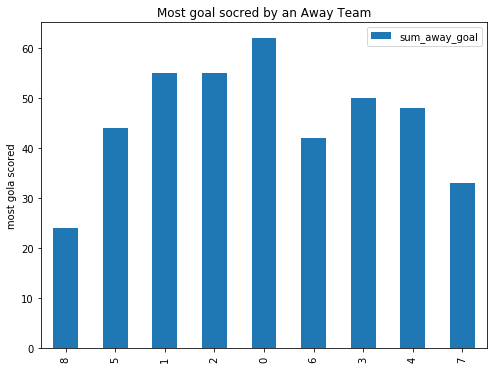

In [17]:
result=Best_away_goal.plot(kind='bar',title='Most goal socred by an Away Team',figsize=(8,6))
result.set_ylabel('most gola scored')

In [18]:

home_or_away=pd.read_sql("""

WITH sub_away AS
(SELECT substr(m.date,1,4)AS year_away,  COUNT(*) AS num_match, t.team_long_name AS away_name,

away_team_api_id AS away_team_id,
SUM(away_team_goal) AS sum_away_goal

FROM match m JOIN Country c ON
c.id=m.country_id
JOIN Team t ON
t.team_api_id =m.away_team_api_id
GROUP BY 1,3,4
ORDER BY 5 DESC,1 DESC,3 DESC),

sub_home AS
(
SELECT substr(m.date,1,4)AS year_home,  COUNT(*) AS num_match, t.team_long_name AS home_name,

home_team_api_id AS home_team_id,
SUM(home_team_goal) AS sum_home_goal

FROM match m JOIN Country c ON
c.id=m.country_id
JOIN Team t ON
t.team_api_id =m.home_team_api_id
GROUP BY 1,3,4
ORDER BY 5 DESC,1 DESC,3 DESC)

SELECT year_away AS year, away_name AS team_name, sum_away_goal, sum_home_goal
FROM sub_away away JOIN sub_home home ON
away.year_away=home.year_home AND away.away_name=home.home_name
ORDER BY 1, 2, 3, 4;""",conn)
                         
home_or_away.head()

,year,team_name,sum_away_goal,sum_home_goal
0,2008,1. FC Köln,12,7
1,2008,AC Bellinzona,7,10
2,2008,ADO Den Haag,12,7
3,2008,AJ Auxerre,6,8
4,2008,AS Monaco,7,15


In [19]:
home_or_away['total_goal']=home_or_away['sum_away_goal']+home_or_away['sum_home_goal']

In [20]:
top_10=home_or_away.groupby(['team_name']).sum().sort_values('total_goal',ascending=False).head(10)

In [21]:
top_10['gap%']=100*(top_10['sum_home_goal']-top_10['sum_away_goal'])/top_10['sum_away_goal']

In [22]:
top_10

,sum_away_goal,sum_home_goal,total_goal,gap%
team_name,,,,
FC Barcelona,354,495,849,39.830508
Real Madrid CF,338,505,843,49.408284
Celtic,306,389,695,27.124183
FC Bayern Munich,271,382,653,40.959410
PSV,282,370,652,31.205674
Ajax,287,360,647,25.435540
FC Basel,275,344,619,25.090909
Manchester City,241,365,606,51.452282
Chelsea,250,333,583,33.200000


In [23]:
bottom_10=home_or_away.groupby(['team_name']).sum().sort_values('total_goal').head(10)

In [24]:
bottom_10['gap%']=100*(bottom_10['sum_home_goal']-bottom_10['sum_away_goal'])/bottom_10['sum_away_goal']

In [25]:
bottom_10

,sum_away_goal,sum_home_goal,total_goal,gap%
team_name,,,,
AC Arles-Avignon,7,14,21,100.000000
Córdoba CF,10,12,22,20.000000
FC Dordrecht,9,15,24,66.666667
Trofense,11,14,25,27.272727
Amadora,10,16,26,60.000000
SpVgg Greuther Fürth,16,10,26,-37.500000
Pescara,12,15,27,25.000000
Uniao da Madeira,8,19,27,137.500000
Feirense,14,13,27,-7.142857


,team_id_aw,team_name_aw,sum_away_goal,num_away_match,avg_away_score
0,8634,FC Barcelona,354,152,2.328947
1,8633,Real Madrid CF,338,152,2.223684
2,8593,Ajax,287,136,2.110294
3,8640,PSV,282,136,2.073529
4,9925,Celtic,306,152,2.013158
5,9823,FC Bayern Munich,271,136,1.992647
6,9772,SL Benfica,247,124,1.991935
7,9773,FC Porto,246,124,1.983871
8,8548,Rangers,147,76,1.934211
9,9931,FC Basel,275,143,1.923077


In [27]:
# what are the teams scored the most during their home game?

home_avg_score=pd.read_sql(
"""
SELECT  home_team_api_id AS team_id_ho,
              ho.team_long_name AS team_name_ho,

SUM(home_team_goal) AS sum_home_goal,

COUNT(*) AS num_home_match,

SUM(home_team_goal)*1.0/COUNT(*) AS avg_home_score


FROM match m JOIN Country c ON
c.id=m.country_id
LEFT JOIN Team ho ON
ho.team_api_id =m.home_team_api_id

GROUP BY 1,2
ORDER BY  5 DESC;
""",conn)

home_avg_score.head(10)

,team_id_ho,team_name_ho,sum_home_goal,num_home_match,avg_home_score
0,8633,Real Madrid CF,505,152,3.322368
1,8634,FC Barcelona,495,152,3.256579
2,9823,FC Bayern Munich,382,136,2.808824
3,8640,PSV,370,136,2.720588
4,8593,Ajax,360,136,2.647059
5,9772,SL Benfica,321,124,2.588710
6,9925,Celtic,389,152,2.559211
7,9931,FC Basel,344,143,2.405594
8,8456,Manchester City,365,152,2.401316
9,9773,FC Porto,295,124,2.379032


In [28]:
# which are the top 10 teams scored the most in all games?


total_avg_score=pd.read_sql(
"""

WITH away AS
(
SELECT  away_team_api_id AS team_id_aw,
              at.team_long_name AS team_name_aw,

SUM(away_team_goal) AS sum_away_goal,

COUNT(*) AS num_away_match,

SUM(away_team_goal)*1.0/COUNT(*) AS avg_away_score


FROM match m JOIN Country c ON
c.id=m.country_id
LEFT JOIN Team at ON
at.team_api_id =m.away_team_api_id
GROUP BY 1,2
ORDER BY  5 DESC),

home AS
(SELECT  home_team_api_id AS team_id_ho,
              ho.team_long_name AS team_name_ho,
SUM(home_team_goal) AS sum_home_goal,
COUNT(*) AS num_home_match,
SUM(home_team_goal)*1.0/COUNT(*) AS avg_home_score

FROM match m JOIN Country c ON
c.id=m.country_id
LEFT JOIN Team ho ON
ho.team_api_id =m.home_team_api_id

GROUP BY 1,2
ORDER BY  5 DESC)

SELECT a.team_id_aw, team_name_aw, sum_away_goal, sum_home_goal,(num_home_match+num_away_match) AS num_match, (sum_away_goal+sum_home_goal)*1.0/(num_away_match+num_home_match) AS avg_score
FROM home h JOIN away a
ON a.team_id_aw=h.team_id_ho
ORDER BY 6 DESC;
""",conn)

total_avg_score.head(10)

,team_id_aw,team_name_aw,sum_away_goal,sum_home_goal,num_match,avg_score
0,8634,FC Barcelona,354,495,304,2.792763
1,8633,Real Madrid CF,338,505,304,2.773026
2,9823,FC Bayern Munich,271,382,272,2.400735
3,8640,PSV,282,370,272,2.397059
4,8593,Ajax,287,360,272,2.378676
5,9772,SL Benfica,247,321,248,2.290323
6,9925,Celtic,306,389,304,2.286184
7,9773,FC Porto,246,295,248,2.181452
8,9931,FC Basel,275,344,286,2.164336
9,8548,Rangers,147,177,152,2.131579


In [29]:
total_avg_score.head(10)['team_name_aw']

0        FC Barcelona
1      Real Madrid CF
2    FC Bayern Munich
3                 PSV
4                Ajax
5          SL Benfica
6              Celtic
7            FC Porto
8            FC Basel
9             Rangers
Name: team_name_aw, dtype: object

In [30]:
# which team improves the most over the years?


#Number of score in 2009

score_09=pd.read_sql(
"""


WITH away AS
(
SELECT  away_team_api_id AS team_id_aw,
              at.team_long_name AS team_name_aw,

SUM(away_team_goal) AS sum_away_goal,

COUNT(*) AS num_away_match,

SUM(away_team_goal)*1.0/COUNT(*) AS avg_away_score


FROM match m JOIN Country c ON
c.id=m.country_id
LEFT JOIN Team at ON
at.team_api_id =m.away_team_api_id

WHERE substr(m.date,1,4) ='2009'

GROUP BY 1,2
ORDER BY  5 DESC),

home AS
(SELECT  home_team_api_id AS team_id_ho,
              ho.team_long_name AS team_name_ho,
SUM(home_team_goal) AS sum_home_goal,
COUNT(*) AS num_home_match,
SUM(home_team_goal)*1.0/COUNT(*) AS avg_home_score

FROM match m JOIN Country c ON
c.id=m.country_id
LEFT JOIN Team ho ON
ho.team_api_id =m.home_team_api_id

WHERE substr(m.date,1,4) ='2009'

GROUP BY 1,2
ORDER BY  5 DESC)

SELECT a.team_id_aw, team_name_aw, sum_away_goal, sum_home_goal,(num_home_match+num_away_match) AS num_match, (sum_away_goal+sum_home_goal)*1.0/(num_away_match+num_home_match) AS avg_score_09
FROM home h JOIN away a
ON a.team_id_aw=h.team_id_ho

ORDER BY 6 DESC;""",conn)

score_09.head(10)


,team_id_aw,team_name_aw,sum_away_goal,sum_home_goal,num_match,avg_score_09
0,8593,Ajax,38,48,34,2.529412
1,10192,BSC Young Boys,40,51,36,2.527778
2,8634,FC Barcelona,39,54,37,2.513514
3,8640,PSV,38,46,34,2.470588
4,8633,Real Madrid CF,37,52,37,2.405405
5,9825,Arsenal,44,42,37,2.324324
6,8721,VfL Wolfsburg,29,48,34,2.264706
7,8548,Rangers,28,50,36,2.166667
8,9931,FC Basel,35,42,36,2.138889
9,9772,SL Benfica,27,41,32,2.125000


In [31]:
# which team improves the most over the years?


#Number of score in 2015

score_15=pd.read_sql(
"""
WITH away AS
(
SELECT  away_team_api_id AS team_id_aw,
              at.team_long_name AS team_name_aw,

SUM(away_team_goal) AS sum_away_goal,

COUNT(*) AS num_away_match,

SUM(away_team_goal)*1.0/COUNT(*) AS avg_away_score


FROM match m JOIN Country c ON
c.id=m.country_id
LEFT JOIN Team at ON
at.team_api_id =m.away_team_api_id

WHERE substr(m.date,1,4) ='2015'

GROUP BY 1,2
ORDER BY  5 DESC),

home AS
(SELECT  home_team_api_id AS team_id_ho,
              ho.team_long_name AS team_name_ho,
SUM(home_team_goal) AS sum_home_goal,
COUNT(*) AS num_home_match,
SUM(home_team_goal)*1.0/COUNT(*) AS avg_home_score

FROM match m JOIN Country c ON
c.id=m.country_id
LEFT JOIN Team ho ON
ho.team_api_id =m.home_team_api_id

WHERE substr(m.date,1,4) ='2015'

GROUP BY 1,2
ORDER BY  5 DESC)

SELECT a.team_id_aw, team_name_aw, sum_away_goal, sum_home_goal,(num_home_match+num_away_match) AS num_match, (sum_away_goal+sum_home_goal)*1.0/(num_away_match+num_home_match) AS avg_score_15
FROM home h JOIN away a
ON a.team_id_aw=h.team_id_ho

ORDER BY 6 DESC;""",conn)

score_15.head(10)


,team_id_aw,team_name_aw,sum_away_goal,sum_home_goal,num_match,avg_score_15
0,8634,FC Barcelona,46,63,38,2.868421
1,8633,Real Madrid CF,38,70,40,2.700000
2,9772,SL Benfica,32,57,34,2.617647
3,9847,Paris Saint-Germain,37,62,38,2.605263
4,8640,PSV,48,38,34,2.529412
5,9823,FC Bayern Munich,34,51,34,2.500000
6,9925,Celtic,42,55,39,2.487179
7,9931,FC Basel,42,45,36,2.416667
8,9789,Borussia Dortmund,31,45,34,2.235294
9,9773,FC Porto,33,40,34,2.147059


In [32]:

df_combined = score_09.merge(score_15,how='inner',left_on='team_name_aw',right_on='team_name_aw')

df_combined['improvement']=(df_combined['avg_score_15']-df_combined['avg_score_09'])/df_combined['avg_score_09']

In [33]:
#who improves the most among the past years among the top 10 teams?


In [34]:
df_combined['team_name_aw'] in FC Barcelona
1      Real Madrid CF
2    FC Bayern Munich
3                 PSV
4                Ajax
5          SL Benfica
6              Celtic
7            FC Porto
8            FC Basel
9             Rangers

.sort_values('improvement',ascending=False)

SyntaxError: invalid syntax (<ipython-input-34-4ef74182ac43>, line 1)

In [35]:
top_10_team=['PSV','Ajax','Real Madrid CF','FC Bayern Munich','SL Benfica','Celtic','FC Porto','FC Basel','Rangers','FC Barcelona']

df_new=df_combined.loc[df_combined['team_name_aw'].isin(top_10_team)].sort_values('improvement',ascending=False)

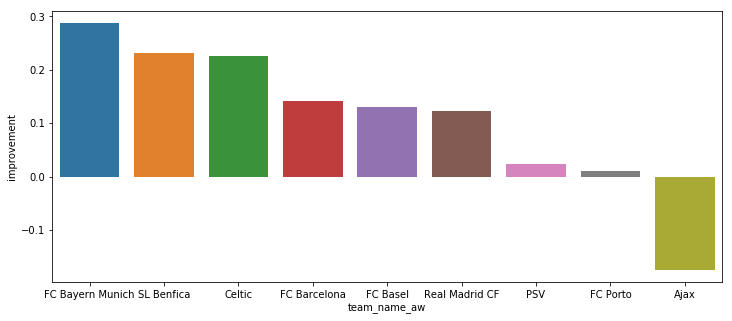

In [37]:
fig, ax = plt.subplots(figsize=(12,5))

sns.barplot(x='team_name_aw',y='improvement',data=df_new,ax=ax)

In [40]:
detailed_matches = pd.read_sql("""SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name='Netherlands'
                                ORDER by date
                                LIMIT 30;""", conn)
detailed_matches


,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,13274,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-29 00:00:00,Vitesse,FC Groningen,0,4
1,13275,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-30 00:00:00,Roda JC Kerkrade,FC Twente,1,1
2,13276,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-30 00:00:00,Willem II,Ajax,2,1
3,13277,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-30 00:00:00,N.E.C.,De Graafschap,2,0
4,13278,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-30 00:00:00,FC Utrecht,PSV,1,5
5,13279,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-31 00:00:00,Heracles Almelo,Feyenoord,3,1
6,13280,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-31 00:00:00,Sparta Rotterdam,ADO Den Haag,2,5
7,13281,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-31 00:00:00,FC Volendam,SC Heerenveen,2,3
8,13282,Netherlands,Netherlands Eredivisie,2008/2009,1,2008-08-31 00:00:00,AZ,NAC Breda,1,2
9,13373,Netherlands,Netherlands Eredivisie,2008/2009,2,2008-09-12 00:00:00,SC Heerenveen,Heracles Almelo,2,2


,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18 00:00:00,BSC Young Boys,FC Basel,1,2
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19 00:00:00,FC Aarau,FC Sion,3,1
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,FC Luzern,FC Vaduz,1,2
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,Neuchâtel Xamax,FC Zürich,1,2
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,FC Basel,Grasshopper Club Zürich,1,0
5,24614,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,AC Bellinzona,Neuchâtel Xamax,1,2
6,24615,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,FC Zürich,FC Luzern,1,0
7,24616,Switzerland,Switzerland Super League,2008/2009,2,2008-07-24 00:00:00,FC Sion,BSC Young Boys,2,1
8,24617,Switzerland,Switzerland Super League,2008/2009,2,2008-07-24 00:00:00,FC Vaduz,FC Aarau,0,2
9,24668,Switzerland,Switzerland Super League,2008/2009,3,2008-07-26 00:00:00,FC Basel,AC Bellinzona,2,0


In [42]:
country_match['country_name'].unique()

array(['Switzerland', 'Poland', 'France', 'Scotland', 'Germany',
       'Belgium', 'England', 'Portugal', 'Netherlands', 'Italy', 'Spain'],
      dtype=object)

In [43]:
country_match['date'] = pd.to_datetime(country_match['date'] )
country_match['year']=country_match['date'].dt.year
country_match['month']=country_match['date'].dt.month

In [44]:
country_match.head()

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,year,month
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18,BSC Young Boys,FC Basel,1,2,2008,7
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19,FC Aarau,FC Sion,3,1,2008,7
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20,FC Luzern,FC Vaduz,1,2,2008,7
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20,Neuchâtel Xamax,FC Zürich,1,2,2008,7
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23,FC Basel,Grasshopper Club Zürich,1,0,2008,7


In [45]:
ctry_avg_score=country_match.groupby(['country_name','year']).mean()[['home_team_goal','away_team_goal']].reset_index('year')
ctry_avg_score['total_goal']=ctry_avg_score['home_team_goal']+ctry_avg_score['away_team_goal']
ctry_avg_score.head(20)

,year,home_team_goal,away_team_goal,total_goal
country_name,,,,
Belgium,2008,1.712418,1.143791,2.856209
Belgium,2009,1.521886,1.208754,2.730640
Belgium,2010,1.627193,1.135965,2.763158
Belgium,2011,1.573913,1.069565,2.643478
Belgium,2012,1.719697,1.325758,3.045455
Belgium,2013,1.312500,1.171875,2.484375
Belgium,2014,1.642458,1.206704,2.849162
Belgium,2015,1.526971,1.215768,2.742739
Belgium,2016,1.861111,1.208333,3.069444


In [47]:
df

country_name,Belgium,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
2008,2.856209,2.585859,2.226316,3.019608,2.467456,3.098039,2.147059,2.104167,2.550847,2.937500,2.839080
2009,2.730640,2.650794,2.381963,2.781046,2.631300,2.777419,2.245833,2.398438,2.400943,2.827027,3.262295
2010,2.763158,2.647059,2.330709,3.032680,2.501312,3.028481,2.281250,2.529167,2.665217,2.702564,3.188889
2011,2.643478,2.883289,2.458115,2.781046,2.579088,3.287671,2.308594,2.521552,2.469636,2.705263,2.788889
2012,3.045455,2.813299,2.534211,2.879085,2.730159,3.171429,2.361607,2.740260,2.771930,2.848718,2.456790
2013,2.484375,2.701613,2.469657,3.081967,2.648649,3.320261,2.607639,2.603113,2.597222,2.905263,2.709497
2014,2.849162,2.723684,2.457895,2.973941,2.629730,3.060606,2.665179,2.350394,2.720000,2.609756,2.922652
2015,2.742739,2.571053,2.454068,2.751634,2.670103,3.026144,2.558594,2.532680,2.754167,2.620513,3.022222
2016,3.069444,2.800000,2.689474,2.843137,2.606635,2.875817,2.652778,2.883333,2.824074,2.909953,3.222222


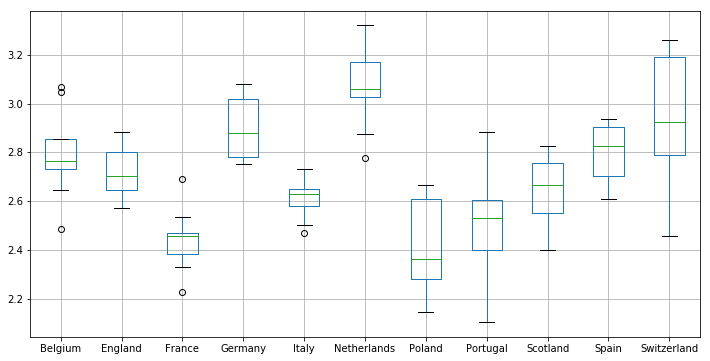

In [91]:
df.boxplot(figsize=(12,6))

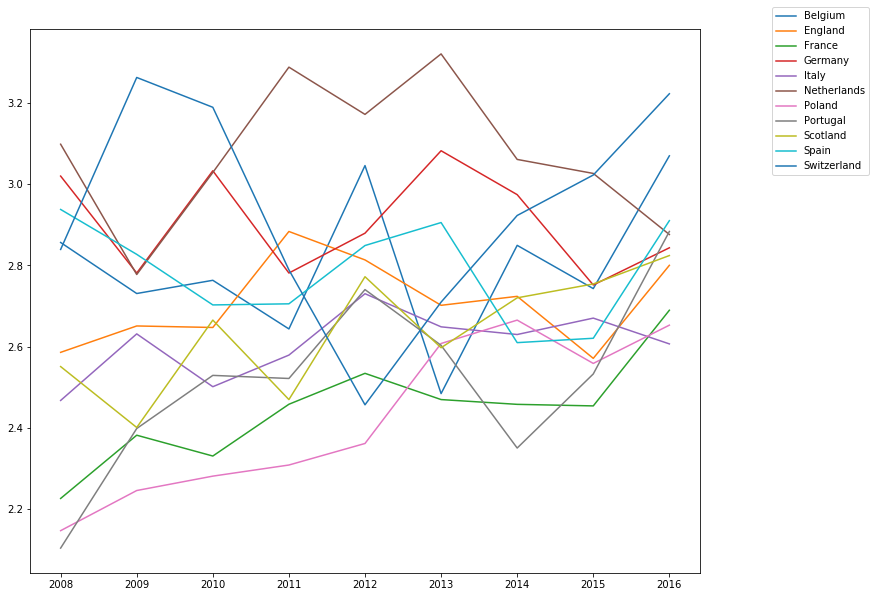

In [48]:
result=df.plot(figsize=(12,10))
result.legend(bbox_to_anchor=(1.1, 1.05))


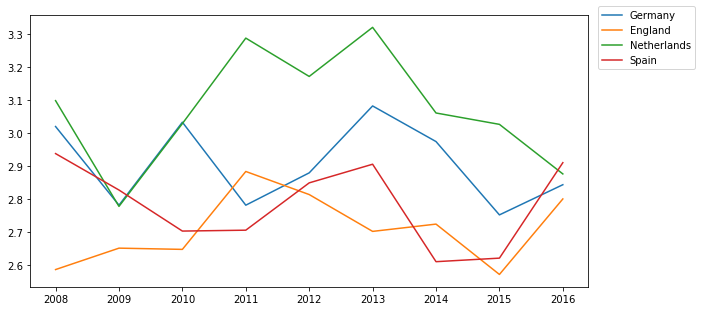

In [59]:
result1=df[['Germany','England','Netherlands', 'Spain']].plot(figsize=(10,5))
result1.legend(bbox_to_anchor=(1.2, 1.05))

In [54]:
#experiment

In [55]:
df

country_name,Belgium,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
2008,2.856209,2.585859,2.226316,3.019608,2.467456,3.098039,2.147059,2.104167,2.550847,2.937500,2.839080
2009,2.730640,2.650794,2.381963,2.781046,2.631300,2.777419,2.245833,2.398438,2.400943,2.827027,3.262295
2010,2.763158,2.647059,2.330709,3.032680,2.501312,3.028481,2.281250,2.529167,2.665217,2.702564,3.188889
2011,2.643478,2.883289,2.458115,2.781046,2.579088,3.287671,2.308594,2.521552,2.469636,2.705263,2.788889
2012,3.045455,2.813299,2.534211,2.879085,2.730159,3.171429,2.361607,2.740260,2.771930,2.848718,2.456790
2013,2.484375,2.701613,2.469657,3.081967,2.648649,3.320261,2.607639,2.603113,2.597222,2.905263,2.709497
2014,2.849162,2.723684,2.457895,2.973941,2.629730,3.060606,2.665179,2.350394,2.720000,2.609756,2.922652
2015,2.742739,2.571053,2.454068,2.751634,2.670103,3.026144,2.558594,2.532680,2.754167,2.620513,3.022222
2016,3.069444,2.800000,2.689474,2.843137,2.606635,2.875817,2.652778,2.883333,2.824074,2.909953,3.222222


In [56]:
imprmnt=pd.DataFrame()
for i in lst :
    imprmnt[i] = df[i].pct_change()

imprmnt

,Switzerland,Poland,France,Scotland,Germany,Belgium,England,Portugal,Netherlands,Italy,Spain
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,0.149067,0.046005,0.069912,-0.058766,-0.079004,-0.043964,0.025112,0.139851,-0.103491,0.066402,-0.037608
2010,-0.022501,0.015770,-0.021518,0.110071,0.090482,0.011909,-0.001409,0.054506,0.090394,-0.049400,-0.044026
2011,-0.125436,0.011986,0.054664,-0.073383,-0.082974,-0.043313,0.089243,-0.003011,0.085584,0.031094,0.000999
2012,-0.119079,0.022964,0.030957,0.122404,0.035253,0.152063,-0.024274,0.086735,-0.035357,0.058575,0.053028
2013,0.102861,0.104180,-0.025473,-0.063027,0.070468,-0.184235,-0.039699,-0.050049,0.046929,-0.029855,0.019849
2014,0.078669,0.022066,-0.004763,0.047273,-0.035051,0.146833,0.008170,-0.097083,-0.078203,-0.007143,-0.101714
2015,0.034068,-0.039992,-0.001557,0.012561,-0.074752,-0.037353,-0.056039,0.077556,-0.011260,0.015353,0.004122
2016,0.066176,0.036811,0.095925,0.025382,0.033254,0.119117,0.089048,0.138452,-0.049676,-0.023770,0.110452


In [60]:
improvement=imprmnt[['Germany','England','Netherlands','Spain']]

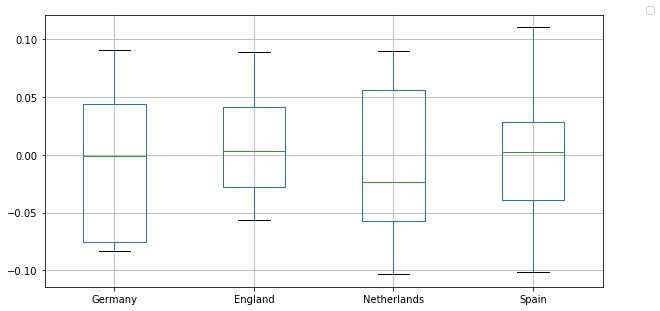

In [65]:
result2=improvement.boxplot(figsize=(10,5))
result2.legend(bbox_to_anchor=(1.1, 1.05))

In [62]:
ctry_avg_score['improvement%']=ctry_avg_score['total_goal'].pct_change()

In [63]:
ctry_avg_score.head()

,year,home_team_goal,away_team_goal,total_goal,improvement%
country_name,,,,,
Belgium,2008,1.712418,1.143791,2.856209,NaN
Belgium,2009,1.521886,1.208754,2.730640,-0.043964
Belgium,2010,1.627193,1.135965,2.763158,0.011909
Belgium,2011,1.573913,1.069565,2.643478,-0.043313
Belgium,2012,1.719697,1.325758,3.045455,0.152063


In [64]:
df_1 = pd.DataFrame(index=np.sort(ctry_avg_score['date'].unique()), columns=ctry_avg_score.index.unique())

lst=['Switzerland', 'Poland', 'France', 'Scotland', 'Germany','Belgium', 'England', 'Portugal', 'Netherlands', 'Italy', 'Spain']
for i in lst:
    df_1.loc[:,i] = list(ctry_avg_score.loc[ctry_avg_score.index==i,'improvement%'])




KeyError: 'date'

In [ ]:
df_1[1:]